### Imports

In [1]:

import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import re
import os

import matplotlib.ticker as ticker
from matplotlib import patheffects

### Read alerts for one scenario

In [2]:
def read_alerts_info(filepath):
    count = {}
    try:
        with open(filepath) as file:
            for line in file:
                try:
                    rule = re.search('rule\" : \"(.+?)\", \"action\"', line).group(1)
                except AttributeError:
                    rule = ':'
                sid = rule.split(":")[1]
                if (sid in count):
                    count[sid] = count[sid]+1
                else:
                    count[sid] = 1 
    except Exception as e:
        print(e)

    return count

### Read alerts

In [3]:
input_folder = "/home/ubuntu/p4-ddos/brum-p4/results/all_pcaps"

data = []
for scenario in os.listdir(input_folder):
    for experiment_round in os.listdir(os.path.join(input_folder, scenario)):
        if "1" not in experiment_round: # Read only one round of each pcap
            continue

        exp = experiment_round.split("_")
        abs_path = os.path.join(input_folder, scenario, experiment_round)
        alerts_per_sid = read_alerts_info(os.path.join(abs_path, "eth0/alert_json.txt"))
        
        data.append([scenario, exp[0], alerts_per_sid])
    
alerts_df = pd.DataFrame(data, columns=["scenario","pcap", "alerts per sid"])

display(alerts_df)


,scenario,pcap,alerts per sid
0,No_rules_with_countmin,Monday,"{'254': 15159, '15935': 2356, '44486': 342, '4..."
1,No_rules_with_countmin,Thursday,"{'254': 13800, '57756': 657, '44604': 332, '15..."
2,No_rules_with_countmin,Friday,"{'15935': 2103, '46373': 426, '44604': 276, '4..."
3,No_rules_with_countmin,Wednesday,"{'254': 15194, '44604': 286, '44484': 696, '44..."
4,No_rules_with_countmin,Tuesday,"{'254': 14909, '44484': 712, '44488': 712, '44..."
5,With_rules_no_countmin,Monday,"{'254': 15030, '27938': 52981, '402': 489, '15..."
6,With_rules_no_countmin,Thursday,"{'57756': 623, '254': 13686, '27938': 57976, '..."
7,With_rules_no_countmin,Friday,"{'15935': 2075, '46373': 423, '402': 342, '254..."
8,With_rules_no_countmin,Wednesday,"{'254': 15182, '1394': 9, '15935': 2188, '2430..."
9,With_rules_no_countmin,Tuesday,"{'254': 14870, '15935': 2385, '57756': 738, '1..."


### Get the priority of each type of classtype

In [4]:
def get_priority_dict(lua_file):
    priority = {}
    start_parsing = False
    try:
        with open(lua_file) as file:
            for line in file:
                if "default_classifications =" in line:
                    start_parsing = True

                if "-- gtp defaults" in line:
                    start_parsing = False

                if start_parsing and "name =" in line:
                    try:
                        name = re.search('name = \'(.+?)\'', line).group(1)
                        p = re.search('priority = (.+?),', line).group(1)
                        priority[name] = p
                    except AttributeError as ae:
                        print("Exception:", ae)
                
    except Exception as e:
        print(e)

    return priority

priority_dict = get_priority_dict("/home/ubuntu/p4-ddos/brum-p4/Network-Wide-Rule-Orchestrator/snort/configuration/snort_defaults.lua") 

### Read rule type and priority

In [5]:
rules_folder = "/home/ubuntu/p4-ddos/brum-p4/Network-Wide-Rule-Orchestrator/snort/rules/snort3-registered"

def get_classtype_from_sid(target_sid):
    for rules_file in os.listdir(rules_folder):
        try:
            with open(os.path.join(rules_folder, rules_file)) as file:
                for line in file:
                    try:
                        sid = re.search(' sid:(.+?);', line).group(1)
                    except AttributeError:
                        sid = ''
                    
                    if target_sid == sid:
                        try:
                            classtype = re.search('classtype:(.+?);', line).group(1)
                        except AttributeError:
                            classtype = ''

                        return classtype
        except Exception as e:
            print(e)


### Function to plot alerts by sid against baseline

['254', '396', '402', '408', '449', '648', '649', '1390', '1394', '3626', '3679', '6699', '8375', '13913', '13974', '14777', '15167', '15168', '15362', '15935', '16642', '17484', '17494', '19559', '19887', '21039', '21545', '23621', '23878', '24094', '24304', '26848', '27721', '27938', '28039', '28069', '28190', '29456', '31614', '31767', '32205', '32481', '32758', '32760', '33561', '33654', '35180', '37025', '37026', '37909', '37915', '38038', '38381', '39320', '39488', '40186', '41379', '42017', '43496', '43687', '44416', '44455', '44484', '44485', '44486', '44487', '44488', '44489', '44604', '44679', '46373', '46387', '48894', '50447', '51127', '52625', '52626', '54307', '57756', '57878']
[0, 2, 1, -1, 0, 1, 0, -798, 0, 0, 0, 0, 1, 0, 98, 112, 1075, 402, 1, 273, 17, 48, 150, 7, 5, 7]


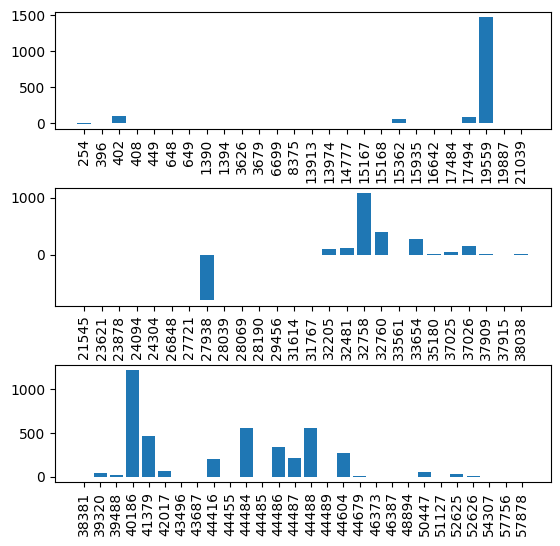

In [6]:
def plot_alerts_histogram(df, baseline, comparison, pcap):
    baseline_data = df.loc[(df["scenario"] == baseline) & (df["pcap"] == pcap), "alerts per sid"].item()
    comparison_data = df.loc[(df["scenario"] == comparison) & (df["pcap"] == pcap), "alerts per sid"].item()

    baseline_sids = set(baseline_data.keys())
    comparison_sids = set(comparison_data.keys())
    all_sids = baseline_sids | comparison_sids

    x,y = [], []
    for sid in sorted([int(x) for x in list(all_sids)]):
        sid = str(sid)
        x.append((baseline_data[sid] if sid in baseline_sids else 0) - (comparison_data[sid] if sid in comparison_sids else 0))
        y.append(sid)

    print(y)

    fig, axes = plt.subplots(nrows=3, ncols=1)
    ax0, ax1, ax2 = axes.flatten()

    one_third = int(len(x)/3)
    slice_ = slice(0, one_third)
    sz = len(x[slice_])
    ax0.bar(range(sz), x[slice_], align='center')
    ax0.set_xticks(range(sz), y[slice_], rotation = 90)

    slice_ = slice(one_third, 2*one_third)
    ax1.bar(range(sz), list(x[slice_]), align='center')
    print(x[slice_])
    ax1.set_xticks(range(sz), list(y[slice_]), rotation = 90)

    slice_ = slice(2*one_third, len(x))
    sz = len(x[slice_])
    ax2.bar(range(sz), list(x[slice_]), align='center')
    ax2.set_xticks(range(sz), list(y[slice_]), rotation = 90)


    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.2)

plot_alerts_histogram(alerts_df, "Baseline_no_sampling", "With_rules_and_countmin", "Monday")

### Function to plot number of alerts of each priority against baseline

In [7]:
sid_classtype_map = {}

def alerts_per_priority(alerts_priority_count, sids_priority_count, num_of_alerts, priority):
    if priority in alerts_priority_count:
        alerts_priority_count[priority]+=num_of_alerts
        sids_priority_count[priority]+=1
    else:
        alerts_priority_count[priority]=num_of_alerts
        sids_priority_count[priority]=1


def snort_alerts_info(df, scenario, pcap):
    alerts_per_sids = df.loc[(df["scenario"] == scenario) & (df["pcap"] == pcap), "alerts per sid"].item()
    sids = set(alerts_per_sids.keys())

    alerts_priority_count, sids_priority_count = {}, {}
    for sid in sorted([int(x) for x in list(sids)]):
        sid = str(sid)
        if sid not in sid_classtype_map:
            classtype = get_classtype_from_sid(sid)
            sid_classtype_map[sid] = classtype
        else:
            classtype = sid_classtype_map[sid]

        priority = priority_dict[classtype]
        if priority in alerts_priority_count:
            alerts_priority_count[priority]+=alerts_per_sids[sid]
            sids_priority_count[priority]+=1
        else:
            alerts_priority_count[priority]=alerts_per_sids[sid]
            sids_priority_count[priority]=1
           
    return len(alerts_per_sids), alerts_priority_count, sids_priority_count


data_list = []
for pcap in alerts_df["pcap"].unique():
    for scenario in alerts_df["scenario"].unique():
        sids_count, alerts_priority_count, sids_priority_count = snort_alerts_info(alerts_df, scenario, pcap)
        data_list.append([scenario, pcap, sids_count, alerts_priority_count, sids_priority_count])

snort_priority_info = pd.DataFrame(data_list, columns=["scenario","pcap", "sids count", "alerts priority count", "sids priority count"])
display(snort_priority_info)

,scenario,pcap,sids count,alerts priority count,sids priority count
0,No_rules_with_countmin,Monday,77,"{'2': 72612, '3': 2194, '1': 7347}","{'2': 21, '3': 13, '1': 43}"
1,With_rules_no_countmin,Monday,32,"{'2': 68155, '3': 532, '1': 3586}","{'2': 11, '3': 7, '1': 14}"
2,Baseline_with_sampling,Monday,64,"{'2': 35026, '3': 1296, '1': 5263}","{'2': 18, '3': 12, '1': 34}"
3,Baseline_no_sampling,Monday,80,"{'2': 72831, '3': 2290, '1': 7356}","{'2': 22, '3': 13, '1': 45}"
4,With_rules_and_countmin,Monday,30,"{'2': 71172, '3': 438, '1': 3683}","{'2': 10, '3': 7, '1': 13}"
5,No_rules_with_countmin,Thursday,93,"{'2': 76997, '3': 4768, '1': 18873}","{'2': 25, '3': 22, '1': 46}"
6,With_rules_no_countmin,Thursday,40,"{'2': 73125, '3': 1446, '1': 2909}","{'2': 14, '3': 12, '1': 14}"
7,Baseline_with_sampling,Thursday,83,"{'2': 33330, '3': 2614, '1': 8025}","{'2': 23, '3': 20, '1': 40}"
8,Baseline_no_sampling,Thursday,93,"{'2': 76722, '3': 4768, '1': 19236}","{'2': 26, '3': 22, '1': 45}"
9,With_rules_and_countmin,Thursday,37,"{'2': 76006, '3': 1447, '1': 2940}","{'2': 13, '3': 12, '1': 12}"


In [13]:
sub_df = snort_priority_info["alerts priority count"].apply(pd.Series)
sub_df.columns = pd.MultiIndex.from_product([["alerts priority count"], sub_df.columns])
sub_df = sub_df.reindex(sorted(sub_df.columns), axis=1)

new_snort_priority_info = pd.concat([snort_priority_info.drop(["alerts priority count"], axis=1), sub_df], axis=1)

sub_df = snort_priority_info["sids priority count"].apply(pd.Series)
sub_df.columns = pd.MultiIndex.from_product([["sids priority count"], sub_df.columns])
sub_df = sub_df.reindex(sorted(sub_df.columns), axis=1)

new_snort_priority_info = pd.concat([new_snort_priority_info.drop(["sids priority count"], axis=1), sub_df], axis=1)

display(new_snort_priority_info)

,scenario,pcap,sids count,"(alerts priority count, 1)","(alerts priority count, 2)","(alerts priority count, 3)","(sids priority count, 1)","(sids priority count, 2)","(sids priority count, 3)"
0,No_rules_with_countmin,Monday,77,7347,72612,2194,43,21,13
1,With_rules_no_countmin,Monday,32,3586,68155,532,14,11,7
2,Baseline_with_sampling,Monday,64,5263,35026,1296,34,18,12
3,Baseline_no_sampling,Monday,80,7356,72831,2290,45,22,13
4,With_rules_and_countmin,Monday,30,3683,71172,438,13,10,7
5,No_rules_with_countmin,Thursday,93,18873,76997,4768,46,25,22
6,With_rules_no_countmin,Thursday,40,2909,73125,1446,14,14,12
7,Baseline_with_sampling,Thursday,83,8025,33330,2614,40,23,20
8,Baseline_no_sampling,Thursday,93,19236,76722,4768,45,26,22
9,With_rules_and_countmin,Thursday,37,2940,76006,1447,12,13,12
